In [30]:
import sys
sys.path.append('../')

from groof.config import *
import rasterio as r
from pathlib import Path
from train import *
import numpy as np
from ee_pipeline import ee_s2
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

In [31]:
prc_dir = Path('data/prc')

evi_fp = PRC / 'evi_median.tif'
ndwi_fp = PRC / 'ndwi_median.tif'
bu_fp = PRC / 'bu_median.tif'



In [32]:
feature_names = S2_BANDS[1:4].copy()
index_names = ['EVI', 'BU', 'NDVI', 'NDPI']
feature_names.extend(index_names)



# feature_names = index_names
with r.open(S2_MEDIAN) as s2:
    s2_arr = s2.read()[1:4]
    mask = s2_arr == -np.inf
    b8a = s2.read(S2_BANDS.index('B8A') + 1)


with r.open(EVI_MEDIAN) as evi:
    evi_arr = evi.read()

with r.open(BU_MEDIAN) as bu:
    bu_arr = bu.read()

# with r.open(NDWI_MEDIAN) as ndmi:
#     ndwi_arr = ndmi.read()

with r.open(NDVI_MEDIAN) as ndvi:
    ndvi_arr = ndvi.read()

with r.open(NDPI_MEDIAN) as ndpi:
    ndpi_arr = ndpi.read()

with r.open(TRAIN) as train:
    y_train_image = train.read()
    y_train_image[y_train_image == np.nan] = 0

with r.open(TEST) as test:
    y_test_image = test.read()
    y_test_image[y_test_image == np.nan] = 0


X_arrays = [s2_arr, evi_arr, bu_arr, ndvi_arr, ndpi_arr]
X_image =  np.concat(X_arrays)
X_image[X_image == -np.inf] = 0
# X_image = np.append(s2_arr,X_image, axis =0)
# X_image = s2_arr
y_labels = {1: 'roof', 2: 'green_roof'}
X_labels =ee_s2.get('bands')
X_labels.append('NDVI')



ts = TrainingSet(
    X_image=X_image,
    X_names = X_labels,
    y_test_image= y_test_image,
    y_train_image= y_train_image,
    y_labels = y_labels,
    rescale = False
)


X_train, X_test, y_train, y_test = ts.get_samples()


# Undersample Dominant Class
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
X_test_res, y_test_res = rus.fit_resample(X_test, y_test)



## Cross Validation

In [33]:

cv = StratifiedKFold(n_splits=5, shuffle=False)

param_grid = {
            'n_estimators': [100, 150, 200],
            'max_features': ['auto', 'sqrt', 'log2'],
            'criterion': ['gini', 'entropy'],
            # 'max_depth': [20, 30],
            # 'min_samples_split': [5,10, 20],
       
            # 'min_samples_leaf': randint(1, 20),
            'max_leaf_nodes': [5, 10, 15, 20 ,40], # Include None as an option
            # 'min_impurity_decrease': [0.001, 0.005, 0.01, 0.03, 0.05], # Small values, can be more specific like [0.0, 0.001, 0.005]
       
            # 'min_samples_leaf': [25, 50],
            'class_weight': ['balanced', 'balanced_subsample' ,None]
        }

cv_search = search_parameters(
    classification_method = 'RandomForest',
    X_train = X_train_res,
    y_train = y_train_res,
    param_grid=param_grid,
    cv=cv,
    scoring = 'f1',
    search_method = 'random'
    
)

Performing Random Search with Classifier: Random Forest Classifier
Parameter Grid:
n_estimators: [100, 150, 200]
max_features: ['auto', 'sqrt', 'log2']
criterion: ['gini', 'entropy']
max_leaf_nodes: [5, 10, 15, 20, 40]
class_weight: ['balanced', 'balanced_subsample', None]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START class_weight=balanced, criterion=gini, max_features=sqrt, max_leaf_nodes=10, n_estimators=100
[CV 1/5; 1/10] END class_weight=balanced, criterion=gini, max_features=sqrt, max_leaf_nodes=10, n_estimators=100;, score=(train=0.918, test=0.877) total time=   0.1s
[CV 2/5; 1/10] START class_weight=balanced, criterion=gini, max_features=sqrt, max_leaf_nodes=10, n_estimators=100
[CV 2/5; 1/10] END class_weight=balanced, criterion=gini, max_features=sqrt, max_leaf_nodes=10, n_estimators=100;, score=(train=0.913, test=0.903) total time=   0.1s
[CV 3/5; 1/10] START class_weight=balanced, criterion=gini, max_features=sqrt, max_leaf_nodes=10, n_est

## Model Assessment

In [34]:
cl = cv_search.best_estimator_
y_pred = cl.predict(X_test_res)
y_proba = cl.predict_proba(X_test_res)
metrics = compute_metrics(y_test_res,y_pred,list(y_proba), y_labels.values())

In [35]:
pd.DataFrame(metrics['report'])

,roof,green_roof,accuracy,macro avg,weighted avg
precision,0.957447,0.820896,0.877193,0.889171,0.889171
recall,0.789474,0.964912,0.877193,0.877193,0.877193
f1-score,0.865385,0.887097,0.877193,0.876241,0.876241
support,114.000000,114.000000,0.877193,228.000000,228.000000


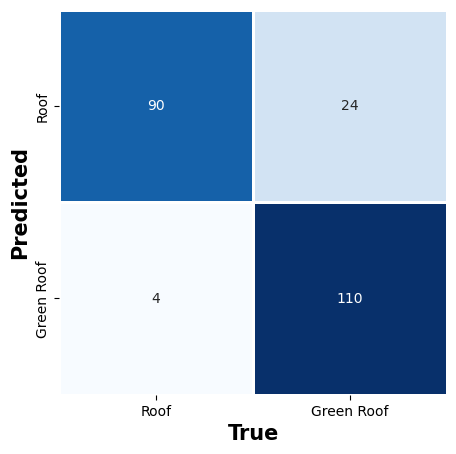

In [36]:
from plot import plot_confusion_matrix


plot_confusion_matrix(
    y_test_res,
    y_pred,
    title ='',
    labels=['Roof', 'Green Roof'],
    figsize = (5,5), 

)

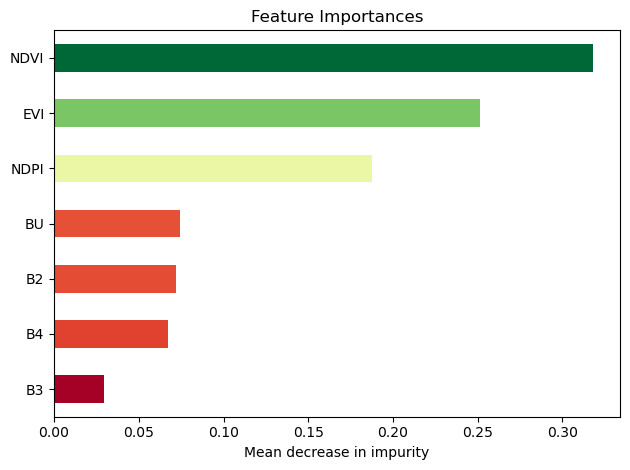

In [37]:
from plot import plot_feature_importances


ft = plot_feature_importances(
    rf = cl,
    title = 'Feature Importances',
    features = feature_names,
    out_file =None
)

## Classify Green Roofs

In [38]:
X = np.append(X_train, X_test, axis = 0)
y = np.append(y_train, y_test, axis = 0)
cl.fit(X,y)

RandomForestClassifier(max_leaf_nodes=5, n_estimators=200)

In [39]:
import rioxarray as rio
import geopandas as gpd
from matplotlib.pyplot import imshow
gdf = gpd.read_file('../data/prc/bldg_class.geojson')

gt = rio.open_rasterio('../data/prc/bldg_groof_groundtruth.tif')

evi=rio.open_rasterio(EVI_MEDIAN)
ndwi=rio.open_rasterio(NDWI_MEDIAN)
bu=rio.open_rasterio(BU_MEDIAN)
ndvi=rio.open_rasterio(NDVI_MEDIAN)
s2 = rio.open_rasterio(S2_MOSAIC_REPROJ).sel(band=slice(1,11))

import xarray as xr

evi.name ='evi'
ndwi.name = 'ndwi'
bu.name = 'bu'
ndvi.name = 'ndvi'
s2.name = 's2'

# ndbi.name = 'ndbi'
X = xr.merge([evi, ndwi, bu, ndvi])

idx = np.random.randint(0,len(gdf) - 1 )
groof1 = gdf.iloc[idx]
X_clip= X.rio.clip([groof1.geometry]).sel(band=1)
X_clip = X_clip.where(X_clip != -np.inf)
X_stack = np.array([X_clip[var].values for var in ['evi','ndwi','bu', 'ndvi']])

X_bldg = predictor_stack(X_stack)
org_shape = X_stack.shape[1:]
img_mask = X_stack != -np.inf
empty = np.zeros(X_stack.shape[1:])


groof_predict = cl.predict(X_bldg).reshape(org_shape)
groof_proba =cl.predict_proba(X_bldg)[:,1].reshape(org_shape)
gt_bldg = gt.rio.clip([groof1.geometry]).sel(band=1).fillna(0.0).values
gt_bldg[gt_bldg == np.nan] = 0.0


from scipy.ndimage import median_filter, minimum_filter, maximum_filter


width, height = groof_predict.shape
kernel_size = (np.array(groof_proba.shape ) / 3).astype(int)
kernel_size[kernel_size < 2] = 3


fig ,ax = plt.subplots(2,5, figsize = (12,7))


import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np

# Example: 0 = background, 1 = roof, 2 = green roof
cmap = ListedColormap(['black', 'lightgrey', 'green'])
# make a color map of fixed colors

filtered = median_filter(groof_proba, size=2)
threshod = np.percentile(groof_proba, q=90)
filtered_classified = np.where(filtered > .7, 2,1)
filtered_classified = median_filter(filtered_classified, size=kernel_size)

bounds=[0,1, 2, 3]
norm = BoundaryNorm(bounds, cmap.N)
ax[0][0].imshow(gt_bldg.astype(int), cmap = cmap, norm = norm, interpolation='nearest',  origin='upper')
ax[0][1].imshow(groof_predict.astype(int), cmap=cmap, norm = norm, interpolation='nearest', origin='upper')
ax[0][2].imshow(filtered_classified.astype(int), cmap=cmap, norm = norm, interpolation='nearest', origin='upper')
# ax[2].imshow(filtered.astype(int), cmap=cmap, norm = norm, interpolation='nearest', origin='upper')
ax[0][3].imshow(filtered, cmap='viridis',)
ax[0][4].imshow(groof_proba, cmap='viridis',)




total = gt_bldg.size
true_px = (gt_bldg == groof_predict).sum()
pct_true = round(true_px / total, 2)
md_true_px = (gt_bldg == filtered_classified).sum()
md_pct_true = round(md_true_px / total, 2)
cl_groof = ((gt_bldg == 2 ) & (groof_predict == 2)).ravel().sum() / (gt_bldg == 2 ).ravel().sum()
cl_f_groof = ((gt_bldg == 2 ) & (filtered_classified == 2)).ravel().sum() / (gt_bldg == 2 ).ravel().sum()

ax[0][0].set_title('Ground Truth')
ax[0][1].set_title(f'Prediction ({pct_true * 100}%)')
ax[0][2].set_title(f'Classified \n Median Filter ({md_pct_true * 100}%)')
ax[0][3].set_title(f'Proba Median Filter')
ax[0][4].set_title('Probability')



ax[1][0].imshow(X_clip.evi, cmap = 'RdYlGn')
ax[1][1].imshow(X_clip.bu, cmap = 'Reds')
ax[1][2].imshow(X_clip.ndwi, cmap = 'RdYlBu' )

ax[1][0].set_title('EVI')
ax[1][1].set_title('BU')
ax[1][2].set_title('NDWI')


for axi in ax.ravel():
    axi.set_xticks([])
    axi.set_yticks([])


ValueError: X has 4 features, but RandomForestClassifier is expecting 7 features as input.